In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
from pydens import add_tokens, Solver, NumpySampler, cart_prod, ConstantSampler
from pydens import plot_loss, plot_pair_1d, plot_2d, plot_sections_2d, plot_sections_3d

In [4]:
add_tokens()

## Уравнение Пуассона на плоскости

$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 5\sin[\pi(x + y)];\quad (x, y) \in [0, 1]^2,\ f(0, y)=f(x, 0)=f(1, y)=f(x, 1)=1.
$$

* устанавливаем размерность задачи

In [6]:
n_dims = 2

* задаем уравнение: "левая - правая часть" 

In [7]:
form = lambda u, x, y: D(D(u,x),x)+D(D(u,y),y)-5*sin(np.pi*(x+y))

* граничное условие

In [8]:
boundary_condition = 1

* генератор точек из области

In [9]:
s = NumpySampler('uniform', dim=2)

* словарь конфигурации для модели

In [10]:
pde = {'n_dims': n_dims,
       'form': form,
       'boundary_condition': boundary_condition}
config = {'pde': pde}

* обучение модели

In [11]:
model = Solver(config)
model.fit(batch_size=150, sampler=s, n_iters=700, bar='notebook')

* график невязки в зависимости от итерации обучения

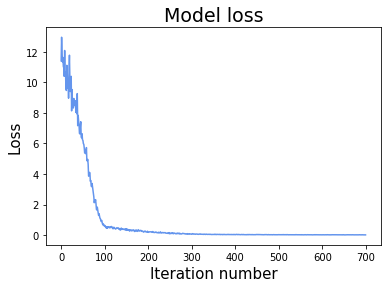

In [12]:
plot_loss(model.loss[:], color='cornflowerblue')

* поведение аппроксимации

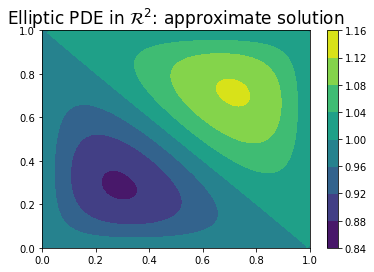

In [13]:
plot_2d(model, 'contourf')

## Параметрическое семейство уравнений на отрезке

$$
\frac{d f}{d t}= \epsilon \pi \cos[\epsilon \pi t]; \quad t \in [0, 1],\ f(0)=1;
$$
$$
\epsilon - \textrm{параметр}, \quad \epsilon \in [1, 5].
$$

Настоящее решение:
$$
\sin[\epsilon \pi t] + 1 - \textrm{синус с переменной фазой}.
$$

* Добавляем букву $P$ в уравнение 

In [ ]:
pde = {'n_dims': 1,
       'form': lambda u, t, e: D(u, t) - P(e)*np.pi*cos(P(e)*np.pi*t),
       'initial_condition': 1}

* Генератор точек на отрезке и значений параметра

In [17]:
s = NumpySampler('uniform')
s = s & NumpySampler('uniform', low=0.5, high=5.5)

In [18]:
s.sample(4)

array([[0.23598662, 2.59045188],
       [0.36569602, 2.18415558],
       [0.74883998, 3.3115091 ],
       [0.29824711, 0.67258882]])

* словарь конфигурации модели

In [19]:
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'dt': lambda u, t, e: D(u, t)}}

процедура обучения

In [20]:
model = Solver(config)
model.fit(batch_size=4500, sampler=s, n_iters=2000, bar='notebook')

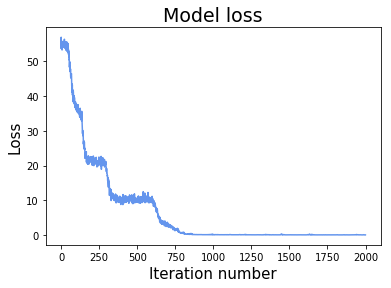

In [21]:
plot_loss(model.loss, color='cornflowerblue')

In [26]:
def plot_pair_custom(e):
    solution = lambda t: np.sin(e * np.pi * t) + 1
    points = np.concatenate([np.linspace(0, 1, 200).reshape(-1, 1),
                             e * np.ones((200, 1))], axis=1)
#     plt.scatter([0.5], [1.0], marker='o', alpha=0.4, s=70, label=r'$u(0.5)=1$')
    plot_pair_1d(model, solution, 'solution', points, plot_coord=0, confidence=0.15,
                 title=r'Настоящее решение и аппроксимация: $\epsilon=$' + str(np.round(e, 2)))

In [27]:
_ = interact(plot_pair_custom, e=(1, 5, 0.01))

interactive(children=(FloatSlider(value=3.0, description='e', max=5.0, min=1.0, step=0.01), Output()), _dom_cl…

## Обратная задача

Ближе к нефтегазу: решаем уравнение теплопроводности на отрезке

$$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} = 5x(1 - x);\quad (x, t) \in [0, 1] \times [0, 1],\ f(x, 0) = 4x(1 - x).
$$

In [28]:
# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, t: D(u, t) - D(D(u, x), x) - 5 * x * (1 - x),
       'initial_condition': lambda x: x * (1 - x) * 4}

# put it together in model-config
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05}}

# uniform sampling scheme
s = NumpySampler('u', dim=2)

In [29]:
# train the network on batches of 100 points
model = Solver(config)
model.fit(batch_size=500, sampler=s, n_iters=1200, bar='notebook')

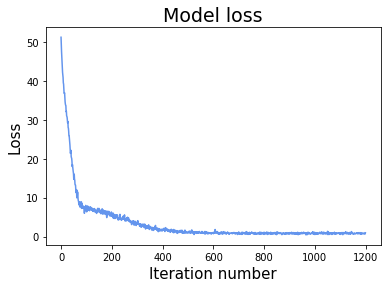

In [30]:
plot_loss(model.loss, color='cornflowerblue')

* посмотрим на решение: видим, что начальное возмущение постепенно вышло на асимптоту

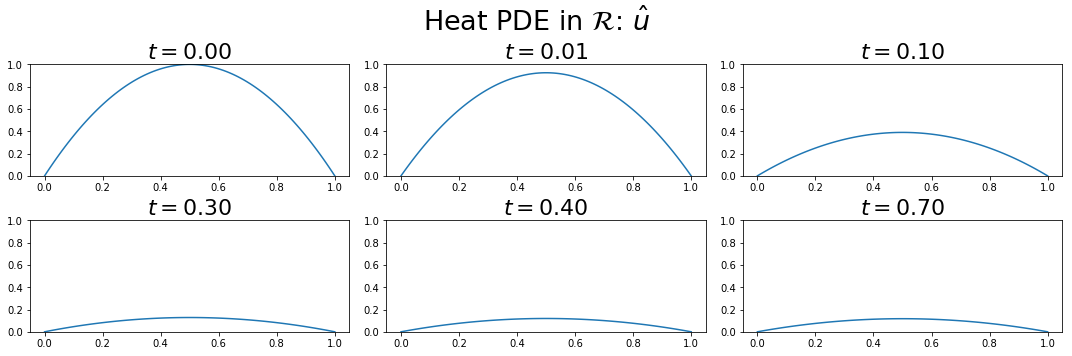

In [31]:
plot_sections_2d(model, timestamps=(0, 0.01, 0.1, 0.3, 0.4, 0.7), ylim=(0.0, 1.0))

..а если мы дополнительно знаем закон изменения давления в центре месторождения?

$$
u(x=0.5, t) = \frac{1}{2}\exp^{-2 t} + \frac{1}{2}.
$$

Выполняется ли этот закон для полученного решения уравнения?

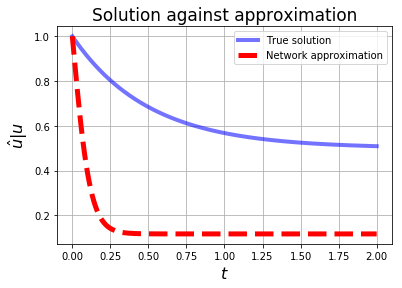

In [32]:
grid = np.concatenate([0.5 * np.ones((200, 1)),
                       np.linspace(0, 2, 200).reshape(-1, 1)], axis=1)
plot_pair_1d(model, lambda x: 0.5 * np.exp(-2 * x) + 0.5, points=grid, plot_coord=1)

Нет! Но это совершенно нормально. Чуть изменим постановку задачи:

* уравнение теплопроводности на прямой с **неизвестным** множителем в правой части:
$$\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} = x(1 - x) * Q(t);\quad (x, t) \in [0, 1] \times [0, 1],\ u(x, 0) = x(1 - x).
$$
и дополнительным ограничением на поведение решения в $x=0.5$:
$$
u(x=0.5, t) = \frac{1}{2}\exp^{-2 t} + \frac{1}{2}.
$$

In [170]:
# trainable rhs
block = {'layout': 'faRfa fa fa. f',
         'units': [15, 15, 15, 15, 1],
         'activation': tf.nn.tanh}

# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, t: D(u, t) - D(D(u, x), x) - 5 * x * (1 - x) * (1 + C(t, 'rhs', **block)),
       'initial_condition': lambda x: x * (1 - x) * 4}

# put it together in model-config
law_at_05 = lambda t: 0.5 * exp(-2 * t) + 0.5
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate':0.2, 'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'u05': lambda u, x, t: u - law_at_05(t)},
          'train_steps': {# adjusting u_hat to be better solution aprox with fixed rhs
                          'uhat_equation': {'scope': '-addendums'},
  
                          # adjusting u_hat to better satisfy additional constraint
                          'uhat_constraint': {'loss': {'name': 'mse', 'predictions': 'u05'}},
                                                    
                          # adjusting conv-rhs for fixed u_hat to be better solution approx
                          'conv_equation': {'scope': 'addendums'}}}

# sampling schemes
s1 = NumpySampler('u') & (NumpySampler('u') * 2.5)
s2 = ConstantSampler(0.5) & (NumpySampler('u') * 2.5)

In [171]:
model = Solver(config)

In [172]:
N_ITERS = 5

In [173]:
model.fit(batch_size=700, sampler=s1, n_iters=3500, train_mode='uhat_equation')

for i in range(N_ITERS):
    model.fit(batch_size=700, sampler=s1, n_iters=100, train_mode='uhat_equation')
    model.fit(batch_size=100, sampler=s2, n_iters=100, train_mode='uhat_constraint')
    model.fit(batch_size=700, sampler=s1, n_iters=100, train_mode='conv_equation')

model.fit(batch_size=200, sampler=s2, n_iters=200, train_mode='uhat_constraint')

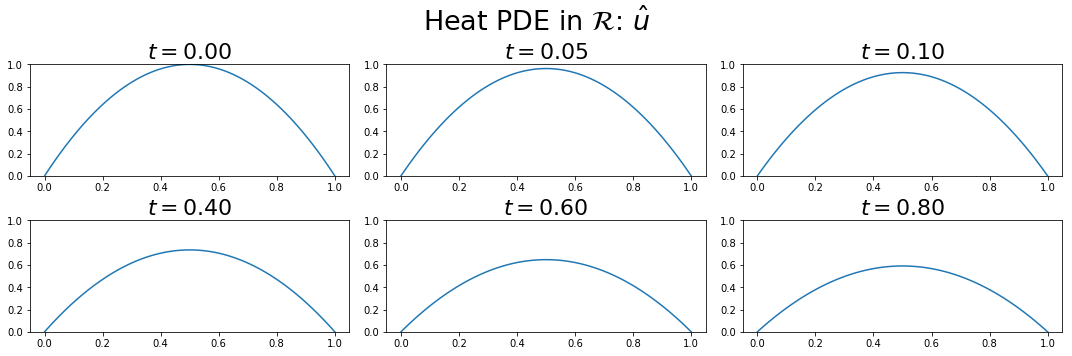

In [174]:
plot_sections_2d(model, timestamps=(0, 0.05, 0.1, 0.4, 0.6, 0.8), ylim=(0.0, 1.0))

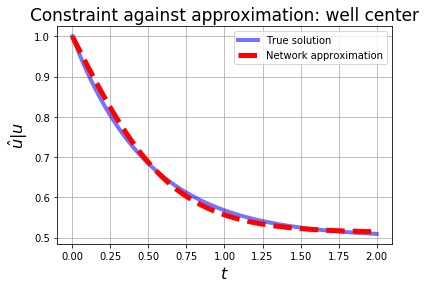

In [175]:
grid = np.concatenate([0.5 * np.ones((200, 1)),
                       np.linspace(0, 2, 200).reshape(-1, 1)], axis=1)
plot_pair_1d(model, lambda x: 0.5 * np.exp(-2 * x) + 0.5, points=grid, plot_coord=1,
             title='Constraint against approximation: well center')